In [1]:
import pandas as pd
file = 'Bakery.csv'
bakery_data = pd.read_csv(file)
bakery_data

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend
...,...,...,...,...,...
20502,9682,Coffee,2017-09-04 14:32:58,Afternoon,Weekend
20503,9682,Tea,2017-09-04 14:32:58,Afternoon,Weekend
20504,9683,Coffee,2017-09-04 14:57:06,Afternoon,Weekend
20505,9683,Pastry,2017-09-04 14:57:06,Afternoon,Weekend


In [2]:
#日毎の販売回数の集計
# Convert the 'DateTime' column to datetime objects
bakery_data['DateTime'] = pd.to_datetime(bakery_data['DateTime'])

# Extract the date from the 'DateTime' column
bakery_data['Date'] = bakery_data['DateTime'].dt.date

# Group by the date and count the number of transactions per day
daily_sales = bakery_data.groupby('Date')['TransactionNo'].nunique()

# Display the first few rows of the daily sales
daily_sales

Date
2016-01-11    77
2016-01-12    47
2016-02-11    83
2016-02-12    61
2016-03-11    95
              ..
2017-11-02    74
2017-11-03    80
2017-12-01    41
2017-12-02    48
2017-12-03    62
Name: TransactionNo, Length: 159, dtype: int64

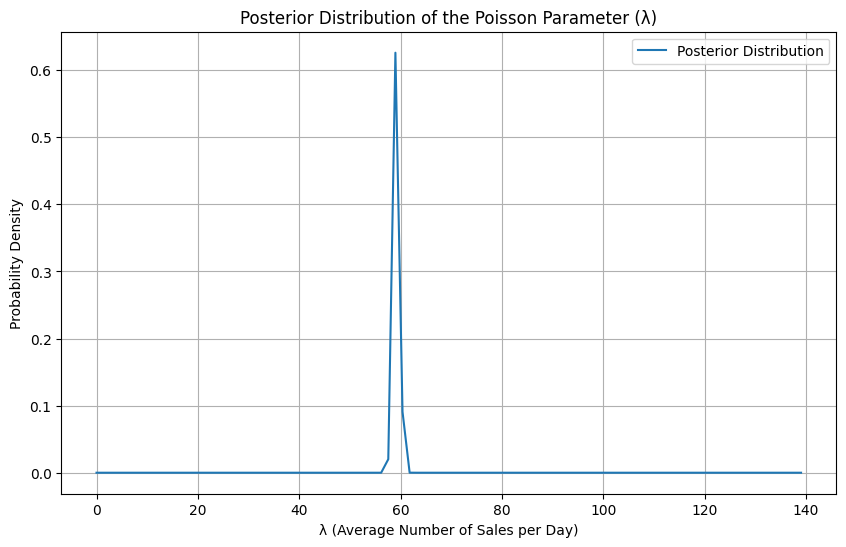

In [3]:
from scipy.stats import gamma, poisson
import numpy as np

# Define the prior parameters for the gamma distribution (alpha and beta)
alpha_prior = 1
beta_prior = 1

# Calculate the posterior parameters
# For gamma-poisson conjugate, the posterior alpha is prior alpha + sum of observed counts
# And posterior beta is prior beta + number of observations
alpha_posterior = alpha_prior + daily_sales.sum()
beta_posterior = beta_prior + len(daily_sales)

# Generate a range of lambda values for plotting the posterior
lambda_values = np.linspace(0, daily_sales.max(), 100)

# Calculate the posterior gamma distribution for these lambda values
posterior_distribution = gamma.pdf(lambda_values, a=alpha_posterior, scale=1/beta_posterior)

# Plot the posterior distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, posterior_distribution, label="Posterior Distribution")
plt.title("Posterior Distribution of the Poisson Parameter (λ)")
plt.xlabel("λ (Average Number of Sales per Day)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Calculate the mode (MAP estimate) of the posterior gamma distribution
if alpha_posterior > 1:
    lambda_map_estimate = (alpha_posterior - 1) / beta_posterior
else:
    lambda_map_estimate = 0

lambda_map_estimate

59.15625

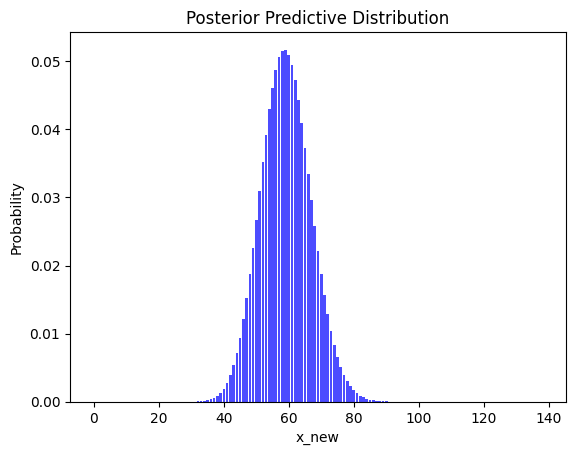

In [61]:
from scipy.stats import nbinom


# 新しいデータ点 x_new が取り得る値の範囲
x_new_values = range(0, daily_sales.max())

# 事後予測分布を計算（負の二項分布を使用）
p_pred = [nbinom.pmf(k=x_new, n=alpha_posterior, p=beta_posterior/(1+beta_posterior)) for x_new in x_new_values]

# 結果をプロット
import matplotlib.pyplot as plt

plt.bar(x_new_values, p_pred, color='blue', alpha=0.7)
plt.title('Posterior Predictive Distribution')
plt.xlabel('x_new')
plt.ylabel('Probability')
plt.show()


In [67]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# 観測データ (実際の売上データを想定)
observed_data = np.array([5, 6, 3, 4, 7])

# PyMC3モデルの定義
with pm.Model() as model:
    # 事前分布としてガンマ分布を指定
    mu = pm.Gamma('mu', alpha=2, beta=1)

    # 観測データとしてポアソン分布を指定
    obs = pm.Poisson('obs', mu=mu, observed=observed_data)

    # 事後分布のサンプリング
    trace = pm.sample(3000)

# MultiTraceからInferenceDataに変換
idata = az.from_pymc(trace)

# 事後分布の可視化
az.plot_trace(idata)
az.plot_posterior(idata)

# 事後予測分布の生成
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=3000)

# MultiTraceからInferenceDataに変換
idata_ppc = az.from_pymc(posterior_predictive=ppc)

# 事後予測分布の可視化
az.plot_ppc(idata_ppc, kind='kde', figsize=(12, 4))


AttributeError: module 'arviz' has no attribute 'from_pymc'

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  59.167  0.609  58.009   60.298      0.011    0.008    2851.0    3666.0   

    r_hat  
mu    1.0  


PPC_Mean = [60.54 58.5  59.14 ... 59.6  59.82 60.12]
PPC_Var = [50.6884 88.93   65.8804 ... 68.     62.8276 62.3056]


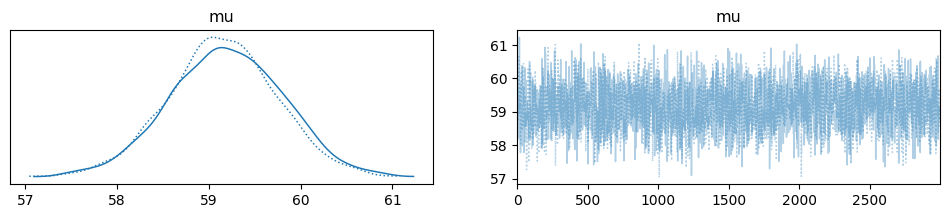

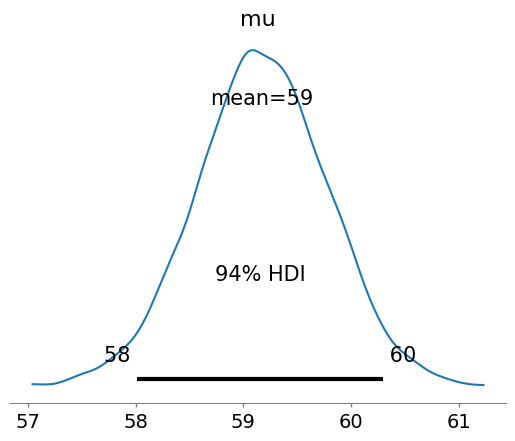

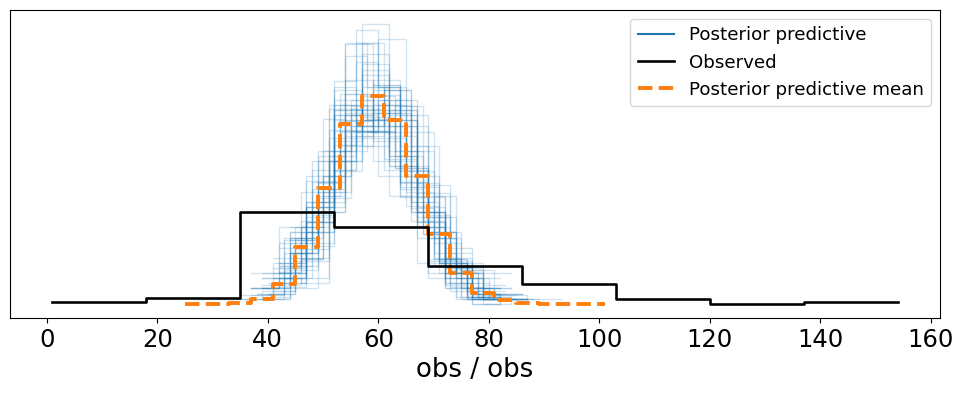

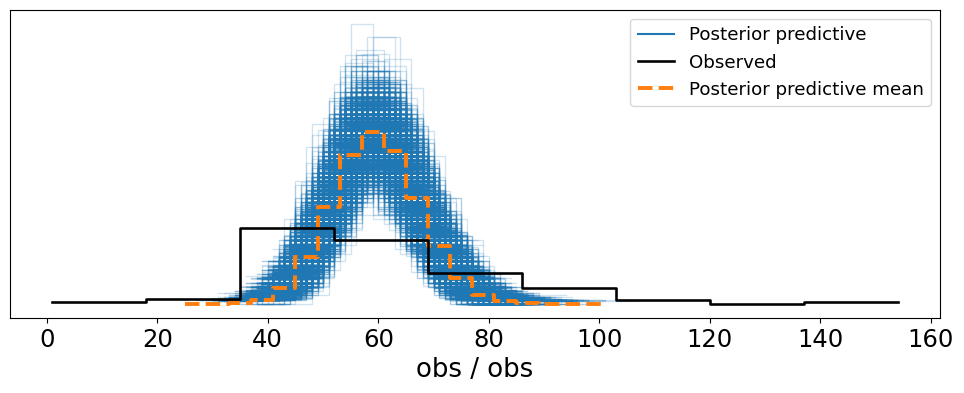

In [72]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma


# 観測データ
x = daily_sales.values  # 観測データの例

with pm.Model() as model:
    mu = pm.Gamma('mu', alpha=2, beta=1) #事前分布
    obs = pm.Poisson('obs', mu=mu, observed=x) #尤度

with model:
    trace = pm.sample(3000, return_inferencedata=False) #定義されたモデルを使って、観測データxからサンプリングされるmuの値を3000個算出している
    idata = pm.to_inference_data(trace) #複数のchainを並行してサンプリング

az.plot_trace(idata) #複数のchainでのmuの分布
print(az.summary(idata)) #統計値の確認
az.plot_posterior(idata) #muの変動の様子

with model: #事後予測分布(事後分布を使って実際のデータの予測)
    ppc = pm.sample_posterior_predictive(idata, return_inferencedata=False) #このidataからサンプルされたパラメータ（この場合はmu）を使って、新しい観測データのサンプルを生成
    idata_ppc = pm.to_inference_data(posterior_predictive=ppc)

# 記述統計量（平均・分散）によるチェック
ppc_samples = ppc['obs']
ppc_samples = ppc_samples.reshape(-1, 50)
ppc_mean = ppc_samples.mean(axis=1)
ppc_var = ppc_samples.var(axis=1)
print('PPC_Mean = {0}'.format(ppc_mean))
print('PPC_Var = {0}'.format(ppc_var))

# 分布によるチェック
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));